In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from sklearn import tree
from IPython.display import Image
import pydotplus as pydot 
warnings.filterwarnings("ignore")
from sklearn.externals.six import StringIO
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.features.importances import FeatureImportances
from sklearn.ensemble import RandomForestClassifier
from numpy import set_printoptions
from sklearn.ensemble import RandomForestClassifier
set_printoptions(precision=3)
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.features.importances import FeatureImportances
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef

In [69]:
Data = pd.read_excel("Gen.xlsx",sheet_name="data").dropna(how = "any")
Data = Data.dropna(how = 'any')

In [70]:
Data.columns

Index(['Cluster', 'Site Name', 'EFFECTIVE_DATE_OF_VISIT',
       'PREVIOUS_DATE_OF_VISIT', 'Months', 'NUMBER_OF_DAYS',
       'GENERATOR_1_CAPACITY_(KVA)', 'CURRENT HOUR METER GE1',
       'PREVIOUS HOUR METER G1', 'PREVIOUS_FUEL_QTE', 'QTE_FUEL_FOUND',
       'QTE_FUEL_ADDED', 'TOTALE_QTE_LEFT', 'CONSUMPTION_HIS', 'RUNNING_TIME',
       'CONSUMPTION_RATE', 'POWER TYPE '],
      dtype='object')

In [71]:
Data['DailyConsumption'] = Data['CONSUMPTION_HIS']/(Data['NUMBER_OF_DAYS'])
Data.loc[~np.isfinite(Data['DailyConsumption']), 'DailyConsumption'] = 0
Data['QTE_Consumed_btn_visit'] = Data['PREVIOUS_FUEL_QTE'] - Data['QTE_FUEL_FOUND']
set_printoptions(precision=3)
Data['QTE_Consumed_btn_visit_Per_Day'] = Data['QTE_Consumed_btn_visit']/(Data['CONSUMPTION_HIS'])
Data.loc[~np.isfinite(Data['QTE_Consumed_btn_visit_Per_Day']), 'QTE_Consumed_btn_visit_Per_Day']= 0
Data['running_time_per_day'] = Data["RUNNING_TIME"]/Data["NUMBER_OF_DAYS"]             
Data.loc[~np.isfinite(Data['running_time_per_day']), 'running_time_per_day'] = 0
set_printoptions(precision=3)
Data['Maximum_consumption_perDay'] = Data[['CONSUMPTION_RATE']]*24
set_printoptions(precision=3)

In [72]:
Data.columns

Index(['Cluster', 'Site Name', 'EFFECTIVE_DATE_OF_VISIT',
       'PREVIOUS_DATE_OF_VISIT', 'Months', 'NUMBER_OF_DAYS',
       'GENERATOR_1_CAPACITY_(KVA)', 'CURRENT HOUR METER GE1',
       'PREVIOUS HOUR METER G1', 'PREVIOUS_FUEL_QTE', 'QTE_FUEL_FOUND',
       'QTE_FUEL_ADDED', 'TOTALE_QTE_LEFT', 'CONSUMPTION_HIS', 'RUNNING_TIME',
       'CONSUMPTION_RATE', 'POWER TYPE ', 'DailyConsumption',
       'QTE_Consumed_btn_visit', 'QTE_Consumed_btn_visit_Per_Day',
       'running_time_per_day', 'Maximum_consumption_perDay'],
      dtype='object')

## Data VISUALIZATION 

Generator consumption between the month of September 2017 and March 2018. The month of September indicates the lowest fuel consumed as the data set received begins from the 20th of the month of September. December indicate the highest consumption in that period of six months and a drastic drop is experienced from the month of December to January.  

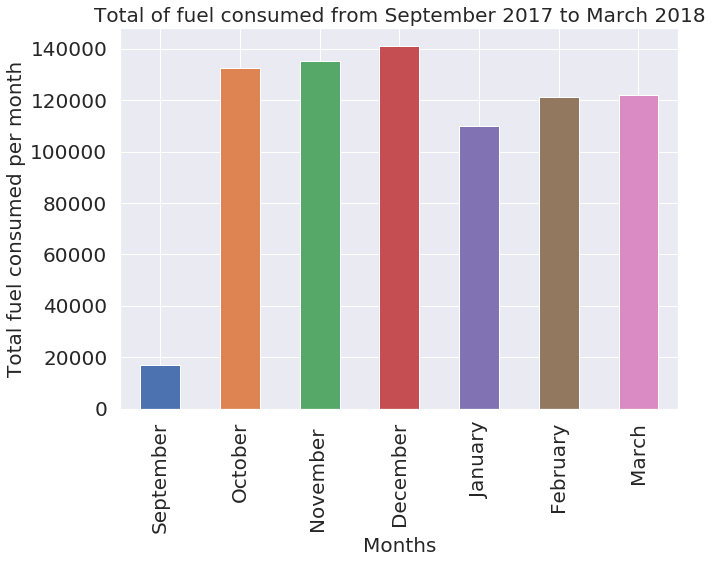

In [73]:
ax = Data.groupby('Months',sort = False)['CONSUMPTION_HIS'].sum().plot(kind= 'bar', figsize=(10,7))
#Sep['CONSUMPTION_HIS'].sum()
plt.title('Total of fuel consumed from September 2017 to March 2018',fontsize=20)
ax.set_ylabel("Total fuel consumed per month", fontsize=20);
plt.xlabel("Months",fontsize=20)
plt.yticks(fontsize=20, rotation=None)
plt.xticks(fontsize=20, rotation=90)
plt.show()

A number of clusters have a minimum of zero fuel consumed and outliers values. KOUSSERI and MORA Cluster have symmetrical distribution on the fuel consumed. Fuel consumed by Ngaoundere 2 have negatively skewed distribution with  extreme outliers. GAROUA 2 and KAELE have positively skewed distribution. Meiganga 2 have extremely positively skewed distribution with a total fuel of 3020 consumed between within the six months.

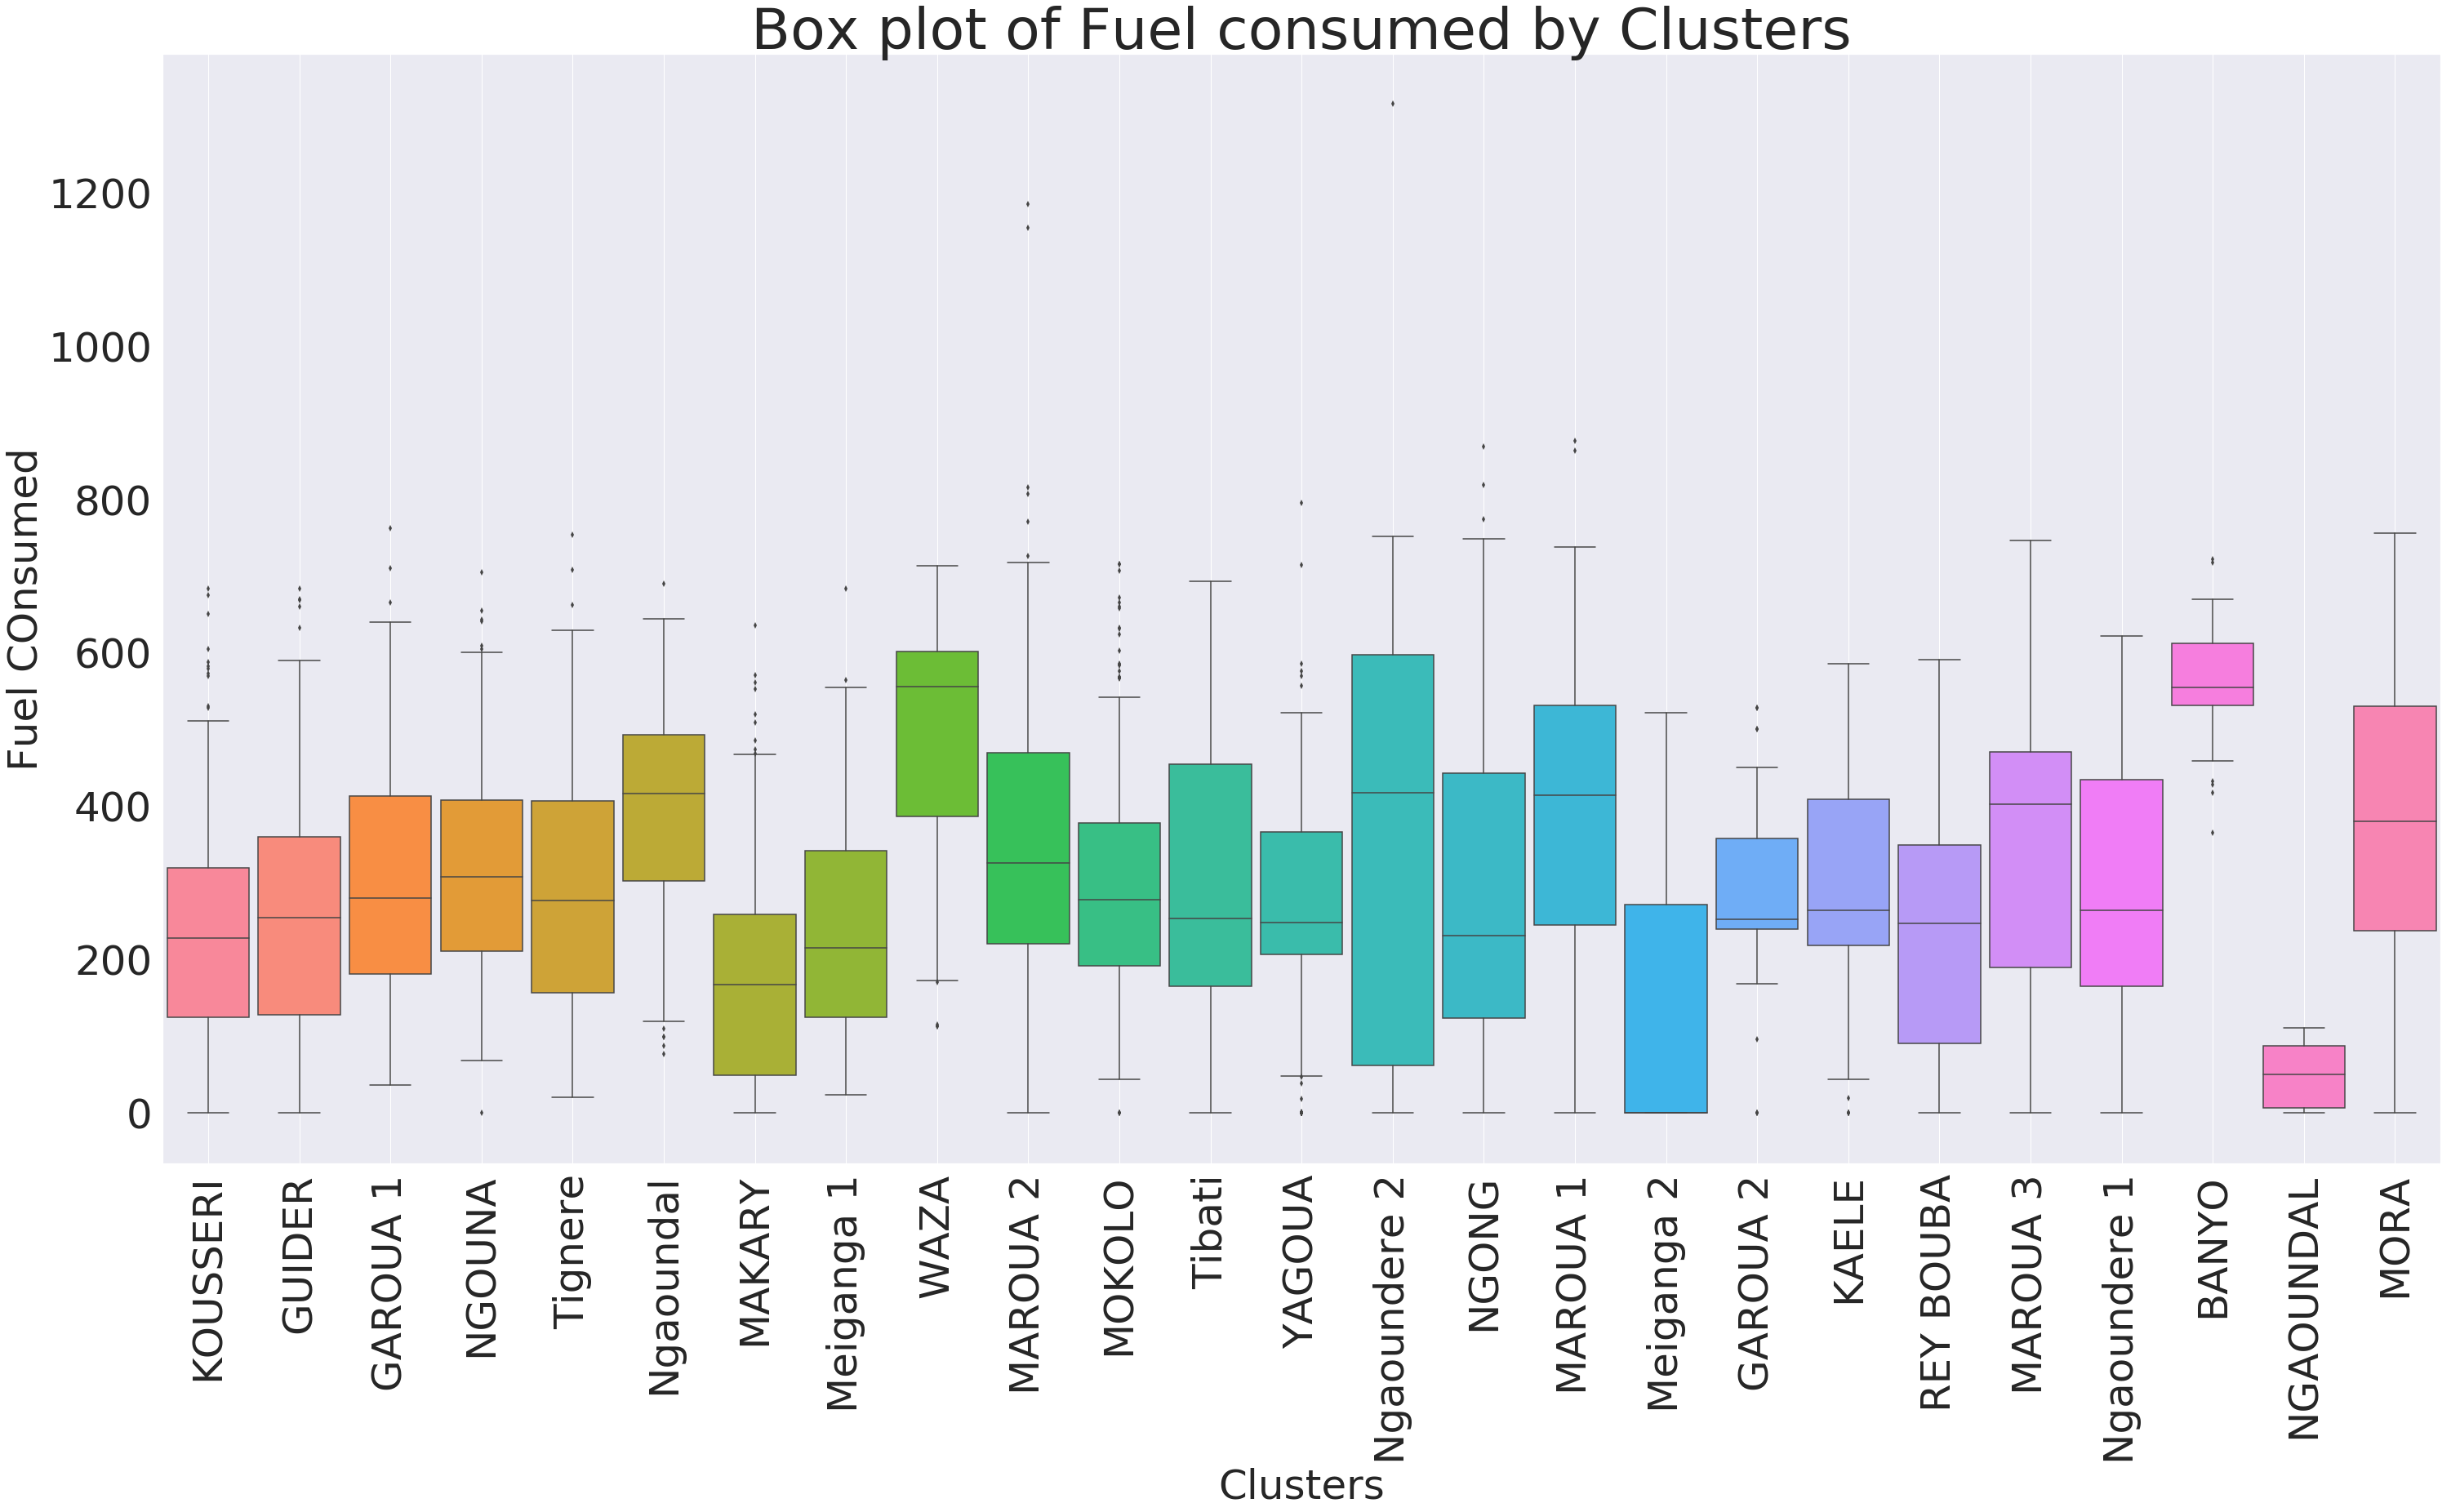

In [74]:
plt.figure(figsize = (50,25))
sns.boxplot(x="Cluster", y= "CONSUMPTION_HIS",data=Data,saturation=10, width=0.9, fliersize=5, whis=1)
plt.title('Box plot of Fuel consumed by Clusters', fontsize=70)
plt.xlabel( "Clusters",fontsize=50)
plt.xticks(fontsize=50, rotation=90)
plt.grid()
plt.yticks(fontsize=50, rotation=None)
plt.ylabel( "Fuel COnsumed",fontsize=50)
plt.show()

The fuel consumed by generator only sites has asymmetry distribution of the probabilities .The mean and standard deviation calculated from the fuel consumed data is  291.11 and 181.54 respectively. The positive skewness of the frequency distribution of 0.46 is as a result of the outliers hence deviating from the mean. Karl Pearson
(1895) , considered skewness as a measure of standardizing the difference between the mean and the mode.  From the box plot above, the minimum fuel consumed in most of the cluster is zero. This is clearly indicated in the normal distribution curve as the curve starts above the normal line. The outliers and the zero consumptions cases indicated the anomalies in the data collected.

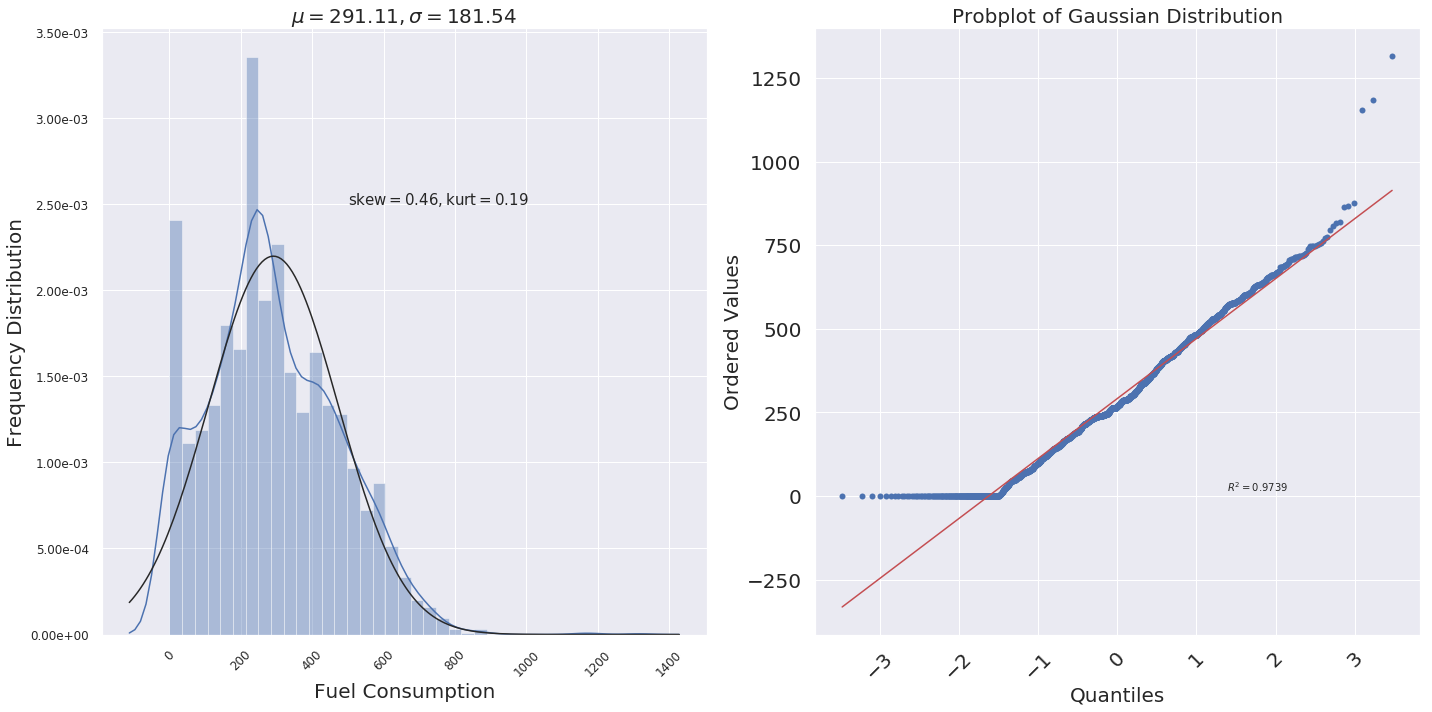

In [75]:
kk = Data['CONSUMPTION_HIS']
import matplotlib.ticker as mtick
from scipy import stats
from scipy.stats import skew,norm
import seaborn; seaborn.set()
%matplotlib inline

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
# kernel density plotsome scatter
ax1 = sns.distplot(kk,fit=norm, kde=True, norm_hist=True);
(mu, sigma) = norm.fit(kk);
ax1.set_title(r'$\mu = %0.2f, \sigma = %0.2f$' %(mu, sigma), fontsize=20)
ax1.set_ylabel(r'Frequency Distribution',fontsize=20)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax1.set_xlabel(r'Fuel Consumption',fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=None)
plt.text(x=500, y= 2.5e-03, s=r'$\rm skew = %0.2f, kurt = %0.2f$' %(kk.skew(), 
                                                                kk.kurt()), fontdict=None, withdash=False, fontsize=15)

ax = fig.add_subplot(122)
res = stats.probplot(kk, plot=plt,rvalue=True)
ax.set_title(r'Probplot of Gaussian Distribution',fontsize=20)
ax.set_ylabel(r'Ordered Values', fontsize=20)
ax.set_xlabel(r'Quantiles', fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20, rotation=None)
plt.tight_layout()



 Data Set
 
The data set has entry from the field on how generator consumed fuel.  The data has observation on the sites that depend on the generator only to power the base station. 

Conditions

1. Generator can only work for at most 24 hours in one day.
2. When the RUNNING_TIME of the generator in the data set  is zero that is, zero fuel consumed. Then the fuel left in the tank of the generator and what was found during the next visit should be equal.  
3. The fuel generator consumed in one day  should not exceed the maximum fuel it can  consume in one day given the rate of consumption. 

 The above stated conditions are to be confirmed in the data collected using the code below. Two classes are generated as whether the information provided is legit or fraudulent.

In [76]:
a = list(Data['RUNNING_TIME'])
b = list(Data['QTE_Consumed_btn_visit'])
c = []
for i in range(len(a)):
    if a[i] == 0  and  b[i]!=0:
        c.append(1)
    else:
        c.append(0)
        
k = list(Data['running_time_per_day'])
v = []
for i in range(len(k)):
    if k[i] > 24 or 0:
        v.append(1)
    else:
        v.append(0)
        
t = list(Data['Maximum_consumption_perDay'])
r = list (Data['DailyConsumption'])
z = []
for i in range(len(r)):
    if r[i] > t[i]:
        z.append(1)
    else:
        z.append(0)
        
        
p = []
for i in range(len(z)):
    if c[i]==0 and z[i]==0 and v[i]==0:
        p.append(0)
    else:
        p.append(1)    
Data['Class'] = p
Data['Class'].unique()

array([0, 1])

The graph below indicates the RUNNING_TIME in one day of different observation. In the sites where the generator is the only  source of power. Out of 2676 observations collected in a period of six months,
771 observation indicated that generator was running for more than 24 hours in one day, this is a pattern that indicates the cumulative time indicates as the total RUNNING_TIME of the generator in one is not true.This anomalies indicated that the information provided about the RUNNING_TIME was wrong. The trend of different generator RUNNING_TIME is as shown.

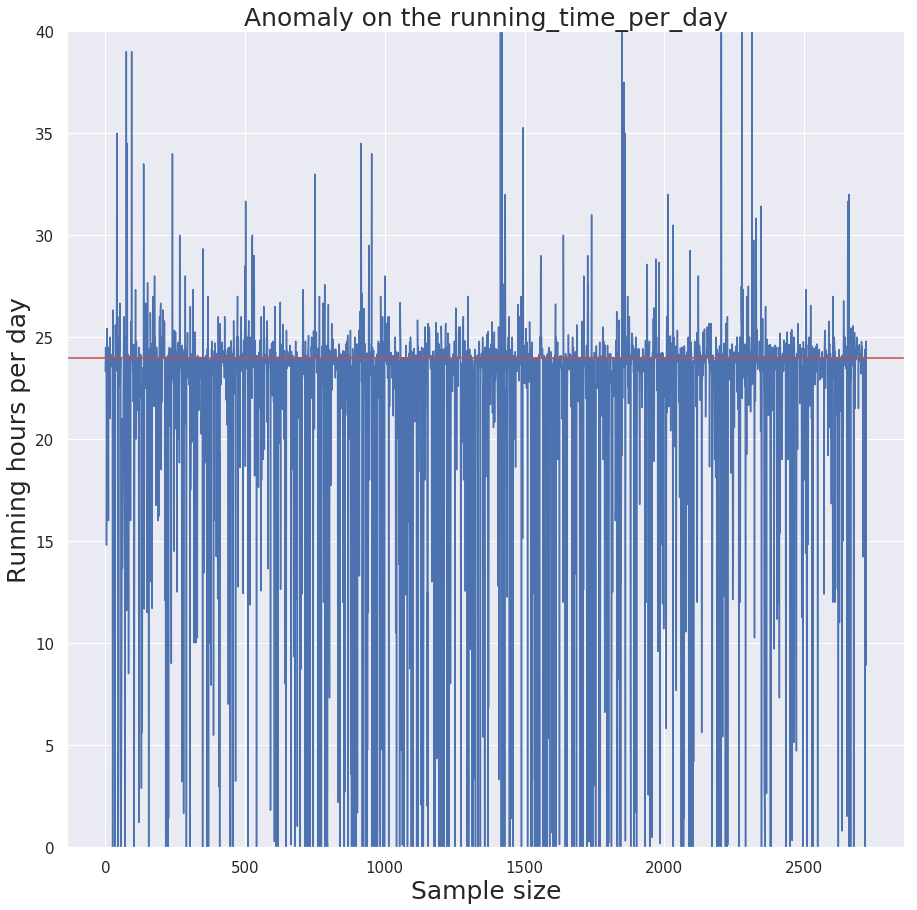

In [77]:
plt.figure(figsize = (15,15)) 
plt.plot( Data['running_time_per_day'], linestyle = '-')
plt.axhline(24, color='r')
plt.title('Anomaly on the running_time_per_day', fontsize = 25)
plt.xlabel('Sample size', fontsize = 25)
plt.ylabel('Running hours per day', fontsize = 25)
plt.xticks(fontsize=15, rotation=None)
plt.yticks(fontsize=15, rotation=None)
plt.ylim(0,40,2)
plt.show()

## Class Label

Class imbalance affect most classification algorithms. The majority class can overtake the algorithm making it to predict only one class with high accuracy. Out of 2676 samples, the sample has 36.66 percent  label of fraud class and 63.34 label of legit class. Class imbalance can be corrected by either under-sampling of legit class, that is , reducing the size of the legit observation into the same size as the fraudulent class or oversampling of the fraudulent class to make multiple observation of the fraudulent class to level both classes into the same sample size.

Fraud cases:981 Fraud cases percentage:36.65919282511211
Valid cases:1695 Valid cases percentage:63.34080717488789


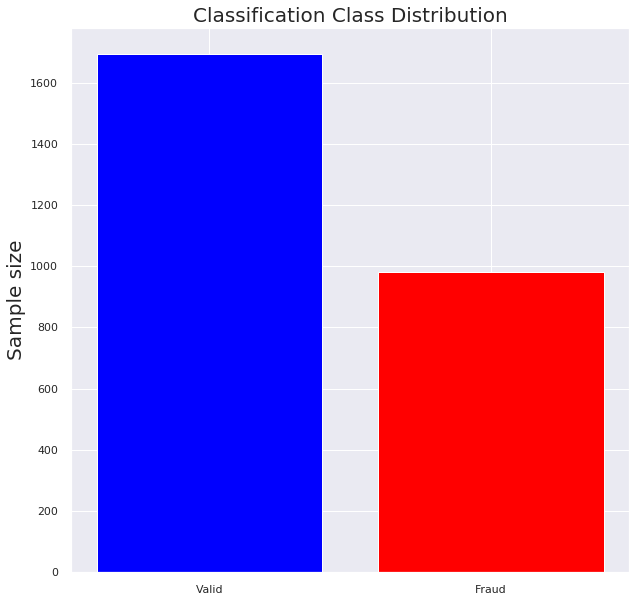

In [78]:
Valid = Data[Data['Class'] == 0]
Fraud =  Data[Data['Class'] == 1]
Fraud_percent = len(Fraud['Class'])/len(Data['Class'])*100
Valid_percent =len(Valid['Class'])/len(Data['Class'])*100

print('Fraud cases:{}'.format(len(Fraud)), 'Fraud cases percentage:{}'.format(Fraud_percent))
print('Valid cases:{}'.format(len(Valid)), 'Valid cases percentage:{}'.format(Valid_percent))
classes = ('Valid', 'Fraud')
y_pos = np.arange(len(classes))
p = [1695, 981]
plt.figure(figsize = (10,10))  
plt.bar(y_pos,p,color=( 'blue','red'))
plt.xticks(y_pos, classes)
plt.ylabel('Sample size',fontsize = 20)
plt.xlabel('',fontsize = 20)
plt.title('Classification Class Distribution', fontsize = 20)
 
plt.show()

The correlation matrix measures the linear relationship between variable in the data set. With strong collection between variable and itself indicated as one and no relation or little relation indicated as zero. Some variable such as the rate of consumption and the NUMBER_OF_DAYS between the visits. There is a positive correlation of 0.81 between total fuel consumed and the number of hours the generator has been running.

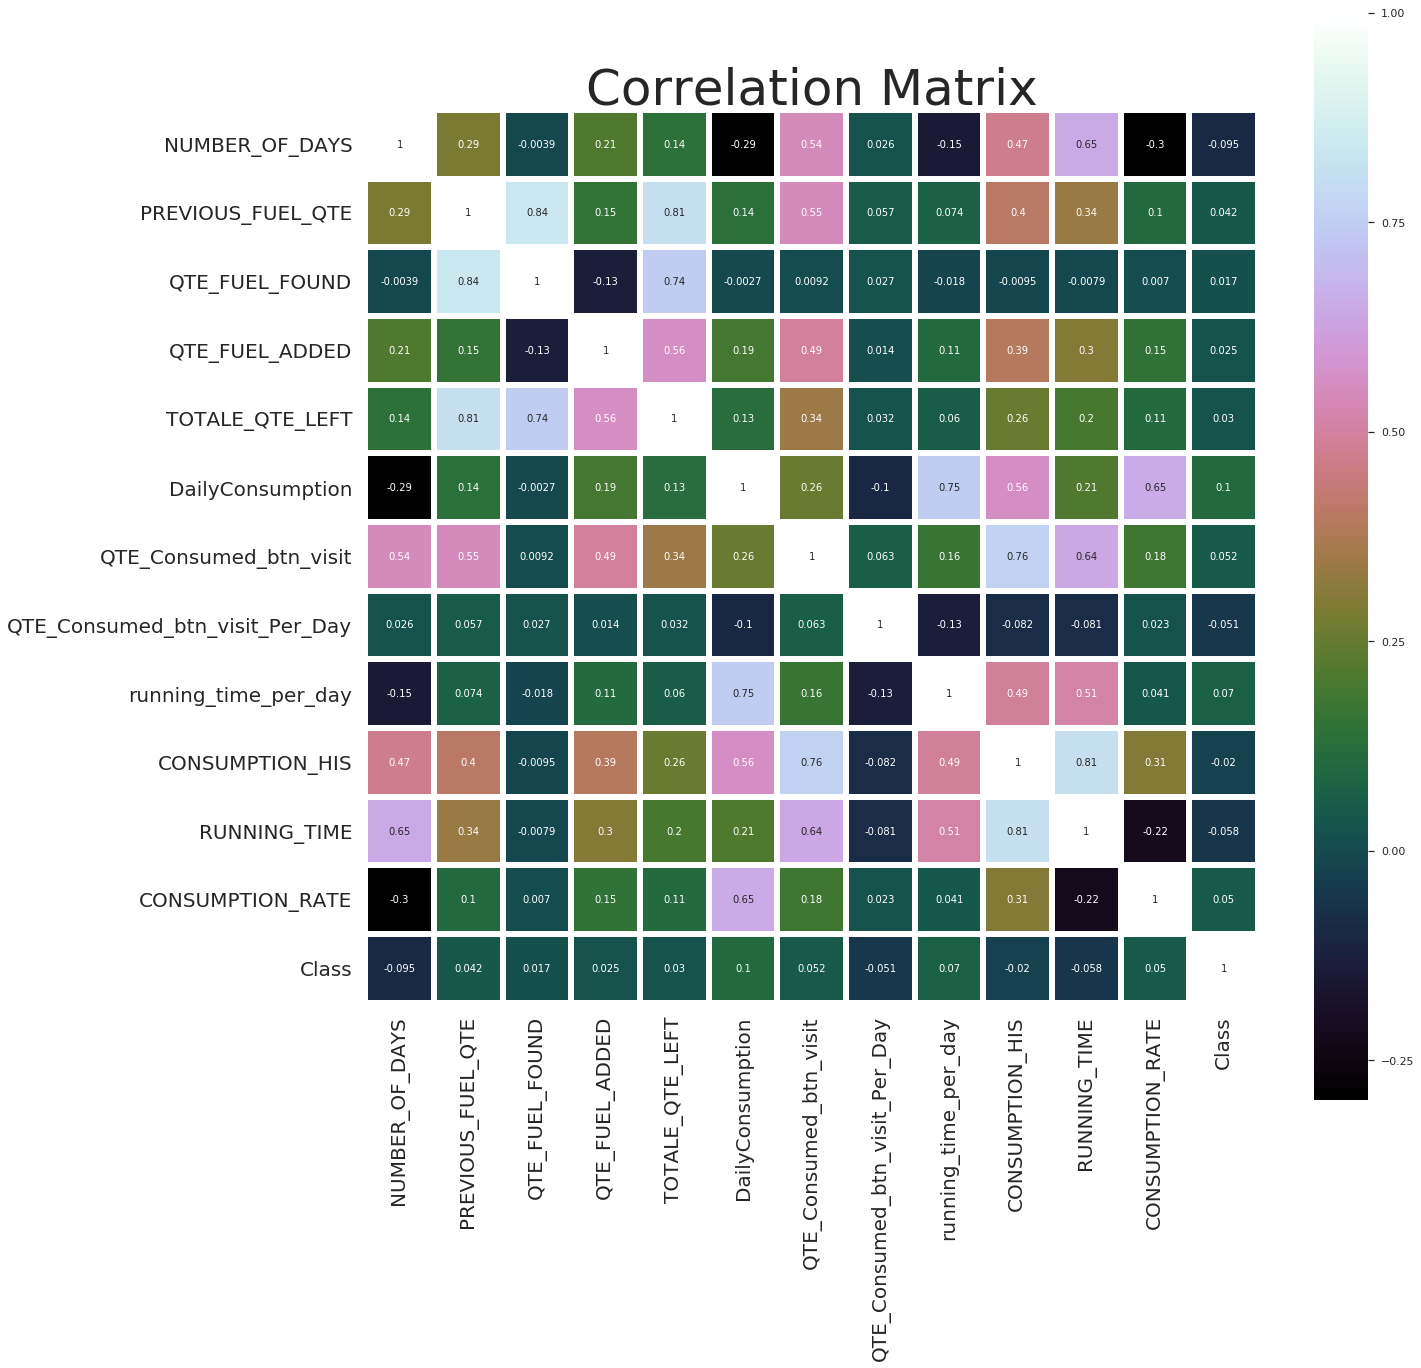

In [79]:
# Correlation heatmap
correlation = Data[['NUMBER_OF_DAYS','PREVIOUS_FUEL_QTE', "QTE_FUEL_FOUND",'QTE_FUEL_ADDED'
                    ,'TOTALE_QTE_LEFT','DailyConsumption',
       'QTE_Consumed_btn_visit','QTE_Consumed_btn_visit_Per_Day', 'running_time_per_day',
                    'CONSUMPTION_HIS','RUNNING_TIME' ,'CONSUMPTION_RATE','Class']].corr()  
plt.figure(figsize = (20,20))  
plt.title("Correlation Matrix", fontsize= 50)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=None)

sns.heatmap(correlation, vmax=1, square=True,  linewidths=5,annot=True, cmap='cubehelix' )  
plt.show()

In [80]:
Data.columns

Index(['Cluster', 'Site Name', 'EFFECTIVE_DATE_OF_VISIT',
       'PREVIOUS_DATE_OF_VISIT', 'Months', 'NUMBER_OF_DAYS',
       'GENERATOR_1_CAPACITY_(KVA)', 'CURRENT HOUR METER GE1',
       'PREVIOUS HOUR METER G1', 'PREVIOUS_FUEL_QTE', 'QTE_FUEL_FOUND',
       'QTE_FUEL_ADDED', 'TOTALE_QTE_LEFT', 'CONSUMPTION_HIS', 'RUNNING_TIME',
       'CONSUMPTION_RATE', 'POWER TYPE ', 'DailyConsumption',
       'QTE_Consumed_btn_visit', 'QTE_Consumed_btn_visit_Per_Day',
       'running_time_per_day', 'Maximum_consumption_perDay', 'Class'],
      dtype='object')

In [81]:
SS = Data[['NUMBER_OF_DAYS', 'CURRENT HOUR METER GE1',
       'PREVIOUS HOUR METER G1', 'PREVIOUS_FUEL_QTE', 'QTE_FUEL_FOUND',
       'QTE_FUEL_ADDED', 'TOTALE_QTE_LEFT', 'CONSUMPTION_HIS',
       'RUNNING_TIME', 'CONSUMPTION_RATE',
        'DailyConsumption','QTE_Consumed_btn_visit','QTE_Consumed_btn_visit_Per_Day', 'running_time_per_day',
       'Maximum_consumption_perDay', 'GENERATOR_1_CAPACITY_(KVA)']]

# Feature Importances

From Gradient boosting feature selection the number of hours the generator is running per day and the fuel  consumed per day has higher influence in the classification class. Quantity of fuel added and total fuel left does not explain the classification class. 

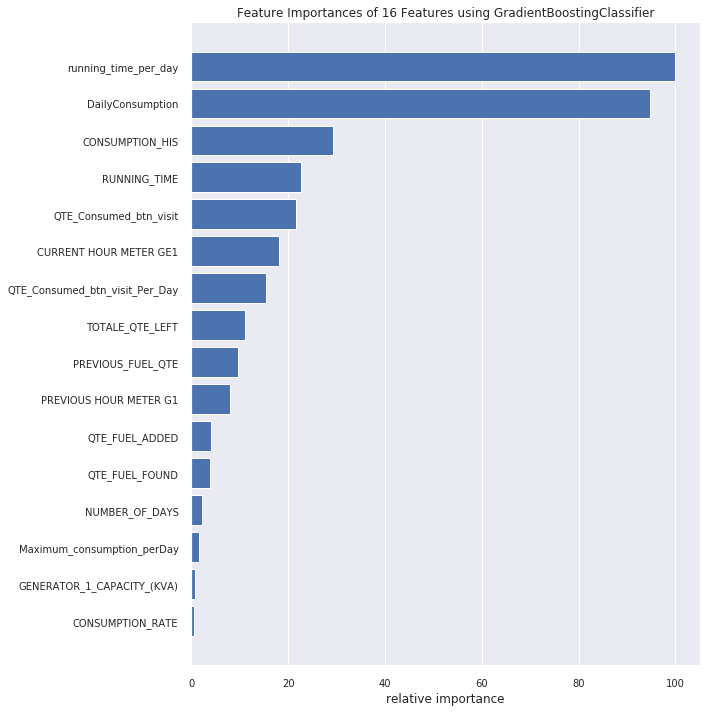

In [82]:
y = Data["Class"]
x_train, x_test, y_train, y_test = train_test_split(SS, y, test_size=0.3, random_state=42)
GB = GradientBoostingClassifier()    
GB = GB.fit(SS,y)
# Create a new matplotlib figure
plt.figure(figsize = (10,10))  
#ax = fig.add_subplot()
viz = FeatureImportances(GradientBoostingClassifier() )
viz.fit(SS, y)
plt.xticks(fontsize=10, rotation=None)
plt.yticks(fontsize=10, rotation=None)
viz.poof()

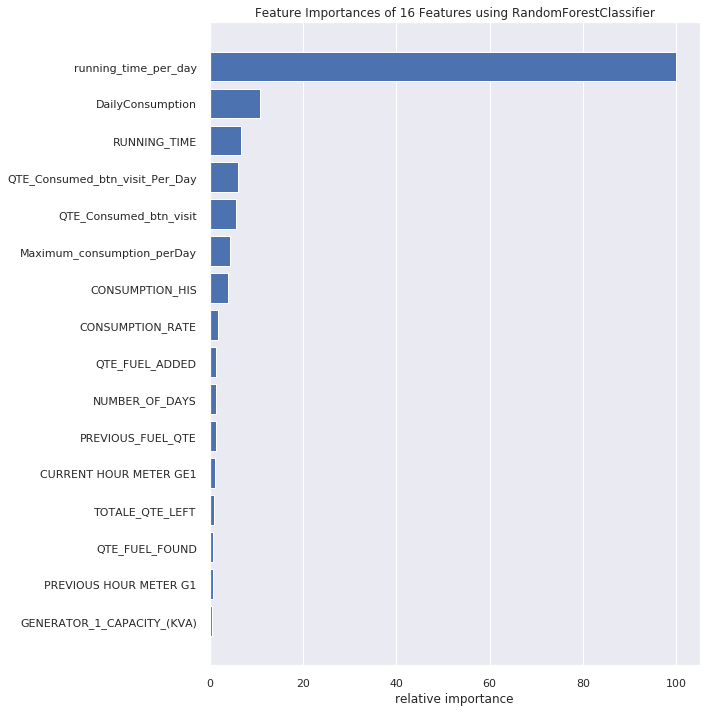

In [83]:
x_train, x_test, y_train, y_test = train_test_split(SS, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=43)      
rf = rf.fit(SS,y)
# Create a new matplotlib figure
plt.figure(figsize = (10,10))  
#ax = fig.add_subplot()
viz = FeatureImportances( RandomForestClassifier(random_state=43) )
viz.fit(SS, y)

viz.poof()

In [84]:
# data = Data[[ 'CONSUMPTION_RATE ','DailyConsumption',
#        'QTE_Consumed_btn_visit_Per_Day', 'running_time_per_day',
#        'Class']]
#Data['Class'] = p

data = Data[['running_time_per_day','DailyConsumption',
             'CONSUMPTION_HIS', 'RUNNING_TIME' , 'Class']]


## Principle Component Analaysis for data visualization

In [85]:

x = data.loc[:,data.columns.tolist()[0:4]]
x = x.as_matrix()

# Standardizing the features
X = StandardScaler().fit_transform(x)
Y = data.loc[:,'Class']


In [86]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
PCAData = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
finalDf = pd.concat([PCAData, data[['Class']]], axis = 1)


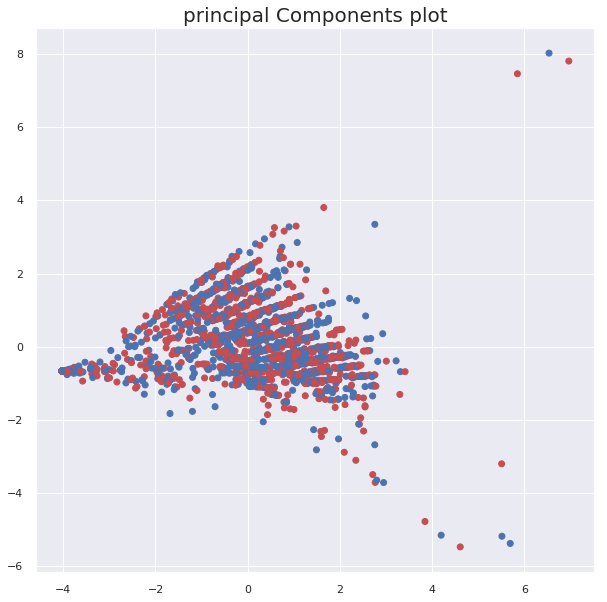

In [87]:
colors = ['r', 'b']
plt.figure(figsize = (10,10))
plt.title("principal Components plot", fontsize= 20)
plt.scatter(finalDf ['PC1'],finalDf ['PC2'],c= colors)
plt.show()

In [88]:
# FUNCTION TO MAKE PREDICTIONS

def predictmodel(model):
    y_pred = model.predict(x_test)
    f,t,thresholds = metrics.roc_curve(y_test,y_pred)
    cm = metrics.confusion_matrix(y_test,y_pred)
    print("Score:", metrics.auc(f,t))
    print("Classification report:")
    print(metrics.classification_report(y_test,y_pred))
    print("Confusion Matrix:")
    print(cm)

# # Support Vector Classifier

Support Vector Classifier is an algorithm used for classification by having an hyperplane between the two class class. The support vector classifier maximize the margin between the two class. The parameter C(cost) and gamma have a great influence on the performance of the model in terms of accuracy.
The parameter C is a penalty parameter in case of misclassification. The large the C the lower the misclassification rate, that is,the model ensure all the train data set are correctly classified  but also can poss an overfitting threat. Lower C allows misclassification with a slack variable error.
The gamaa parameter explains how a single input have a influence in the model, low gamma means a single input have low influence in the model.

In the case the class is non separable the class. slack variable is introduced to the model that allows misclassification of the model. 

In the case a class is not linearly separable a non linear kernel function are used to separate the two class. This includes radial, exponential and polynomial kernel. 

With a non linear kernel , radial, we fit the model with first four importance variables from feature selection. Classification classes; class 0:- normal , class 1:-anomaly. With an optimal grid search of parameter C = 1000 and gamma 0.001. The model had an accuracy of 94% . Out of 536 test data, 313 were correctly predict as positive(True Positive) and 15 misclassified as positive(False positive) and out of 208 fraud sample, 192 was correctly classified(True Negative) and 16(False Negative). From the receiver operating characteristic ,the Area under the curve of the support vector classifier is 97%.The Mathew correlation Coeffient value for the SVC is rated at 0.87 . 

Score: 0.9386726078799249
Classification report:
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       328
          1       0.93      0.92      0.93       208

avg / total       0.94      0.94      0.94       536

Confusion Matrix:
[[313  15]
 [ 16 192]]


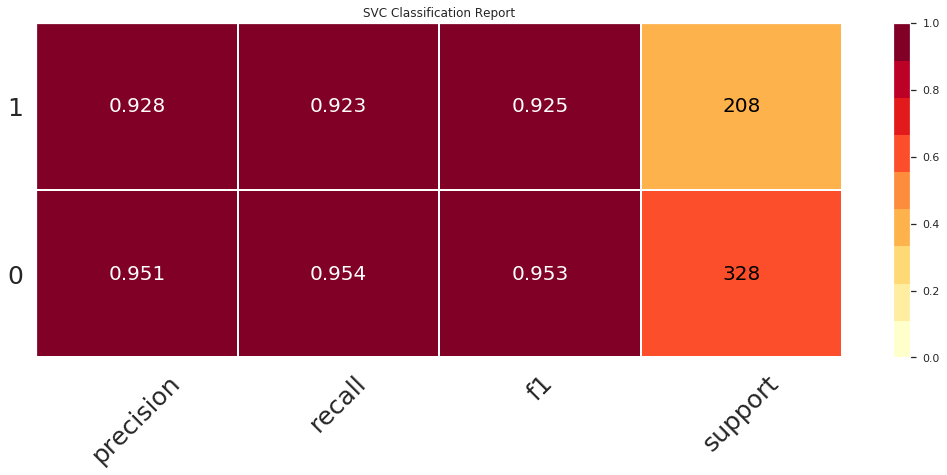

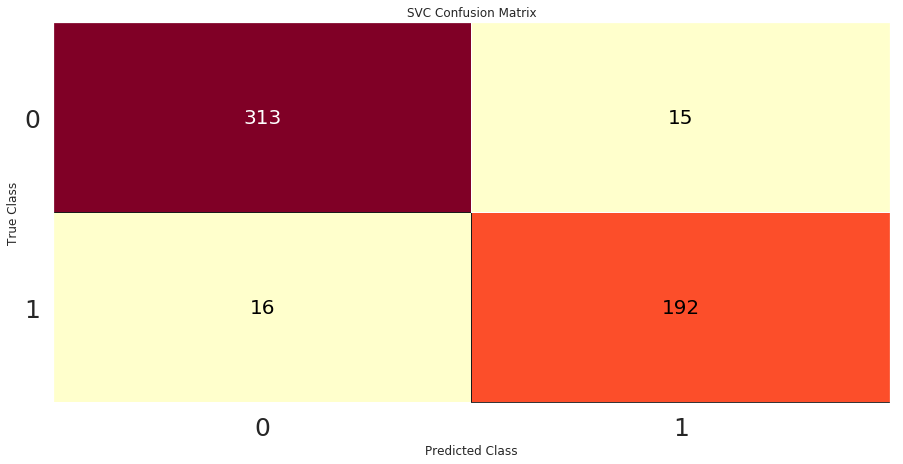

In [89]:
x = data.loc[:,data.columns.tolist()[0:4]]
x = x.as_matrix()
Y = data.loc[:,'Class']
Y = Y.as_matrix()
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size=0.20,random_state=2700) 
SVM =SVC(kernel="rbf", C=1000, gamma = 0.001, decision_function_shape=None, probability=True)
SVM.fit(x_train , y_train)
predictmodel(SVM)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20
visualizer = ClassificationReport(SVM,cmap='YlOrRd', support=True)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)

visualizer.poof()
cm = ConfusionMatrix(SVM, classes=[0,1])
cm.fit(x_train, y_train)
cm.score(x_test, y_test)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)

cm.poof()

The parameter C plotted against accuracy. The accuracy  increases with an increases in C and stagnate after C= 400.

## Plot of accuracy against parameter C 

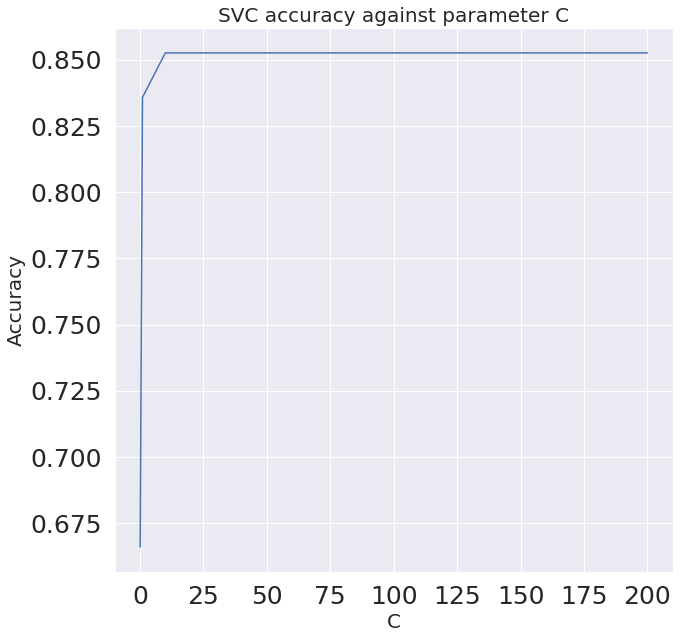

In [90]:
P = [0.1,1,10, 100,200]
L = []
jj = []
for i in range(len(P)):
    scv = SVC(C=P[i])   
    scv.fit(x_train, y_train)
    L.append(scv.score(x_test, y_test))
    jj.append(cross_val_score(scv, x_test, y_test).std())
#print(L)
#print(jj)
plt.figure(figsize = (10,10))
plt.plot(P,L)
plt.xlabel("C",  fontsize = 20)
plt.title("SVC accuracy against parameter C",  fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)
cm.poof()
plt.show()

## ROC Curve

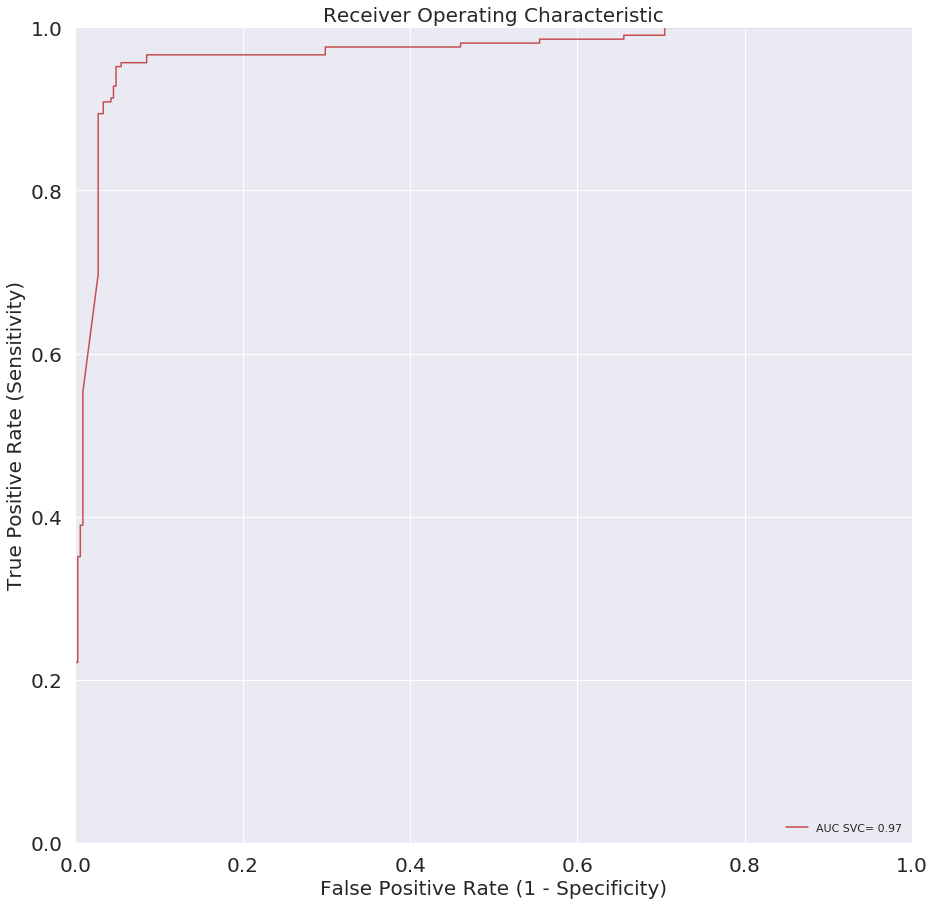

In [91]:
y_pred_prob = SVM.predict_proba(x_test)[:, 0]
y_pred_probs = SVM.predict_proba(x_test)[:, 1]
y_pred_probC = SVM.predict_proba(x_test)
y_pred= SVM.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs)
Roc_Auc = auc(fpr, tpr)
plt.figure(figsize = (15,15))
plt.plot(fpr, tpr, color = 'r', label = 'AUC SVC= %0.2f' % Roc_Auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 'lower right')
plt.rcParams['font.size'] = 12
plt.yticks(fontsize=20, rotation=None)
plt.xticks(fontsize=20, rotation=None)
plt.title('Receiver Operating Characteristic' , fontsize = 20)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 20)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 20)
plt.grid(True)
plt.show()

In [92]:
SVM.fit(x_train, y_train)  
SVM.score(x_train, y_train)
# Predictions/probs on the test dataset
SMpredicted = pd.DataFrame(SVM.predict(x_test))  
SMprobs = pd.DataFrame(SVM.predict_proba(x_test))
# Store metrics
svm_accuracy = metrics.accuracy_score(y_test, SMpredicted)  
svm_roc_auc = metrics.roc_auc_score(y_test, SMprobs[1])  
svm_confus_matrix = metrics.confusion_matrix(y_test, SMpredicted)  
svm_mcc = matthews_corrcoef(y_test, SMpredicted)  
svm_classification_report = metrics.classification_report(y_test,SMpredicted)  
svm_precision = metrics.precision_score(y_test, SMpredicted, pos_label=1)  
svm_recall = metrics.recall_score(y_test, SMpredicted, pos_label=1)  
svm_f1 = metrics.f1_score(y_test, SMpredicted, pos_label=1)
# Evaluate the model using 10-fold cross-validation
svm_cv_scores = cross_val_score(SVM, x_test, y_test, scoring='precision', cv=5)  
svm_cv_mean = np.mean(svm_cv_scores)
svm_cv_mean

0.7783458646616541

In [93]:
svm_mcc

0.878124268513269

# # Nueral Network- MultiLayer Percetron (MLP)

This a nueral Network model use in classification. The input variable is a signed to a weight fuction and the product of the weight function and input variable is passed to the next layer where the non linear activation function is applied into the summation. The sigmoid activation functon have been used in most application of neural network.

In [94]:
def predictmodelMLP(model):
    y_pred = model.predict(x_tests)
    f,t,thresholds = metrics.roc_curve(y_tests,y_pred)
    cm = metrics.confusion_matrix(y_tests,y_pred)
    
    print("Score:", metrics.auc(f,t))
    print("Classification report:")
    print(metrics.classification_report(y_tests,y_pred))
    print("Confusion Matrix:")
    print(cm)

Score: 0.9222560975609756
Classification report:
             precision    recall  f1-score   support

          0       1.00      0.84      0.92       328
          1       0.80      1.00      0.89       208

avg / total       0.92      0.90      0.91       536

Confusion Matrix:
[[277  51]
 [  0 208]]
Training set score: 0.976168
Test set score: 0.904851


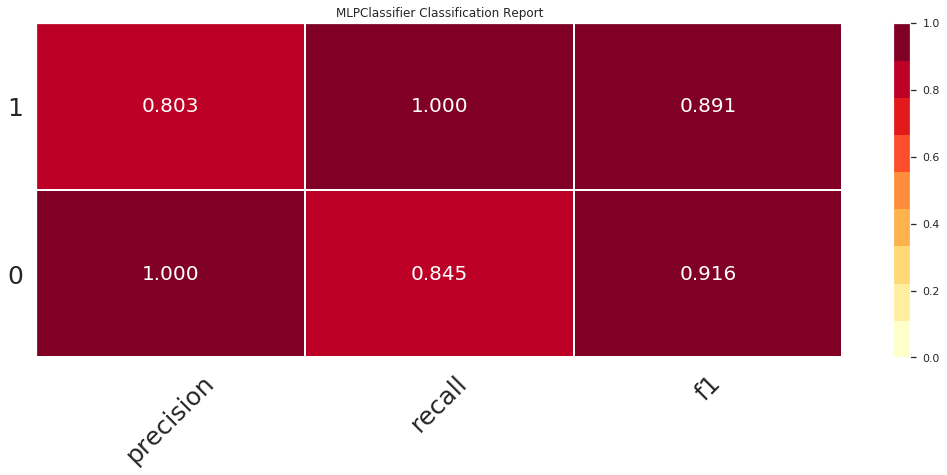

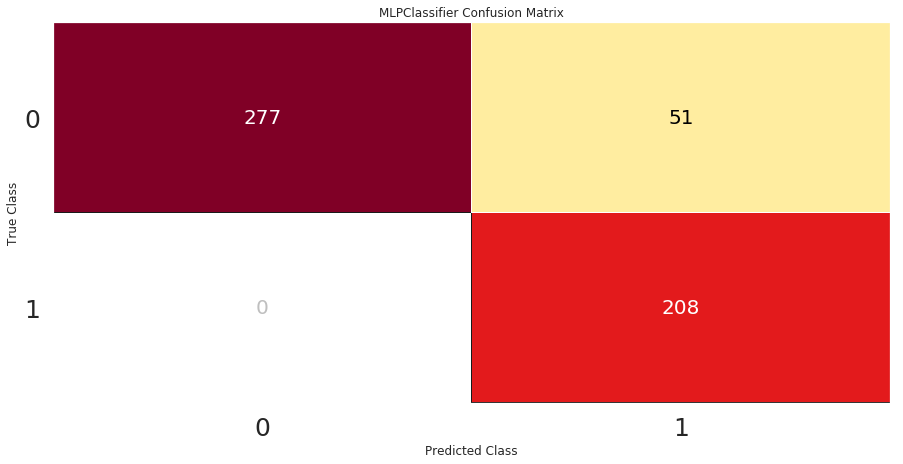

In [95]:
x = data.loc[:,data.columns.tolist()[0:4]]
x = x.as_matrix()
Y = data.loc[:,'Class']
Y = Y.as_matrix()
x_trains,x_tests,y_trains,y_tests = train_test_split(x,Y,test_size=0.2,random_state=2700)
scaler = StandardScaler()
scaler.fit(x_trains)
x_trains = scaler.transform(x_trains)
scaler.fit(x_tests)
x_tests = scaler.transform(x_tests) 

clf = MLPClassifier(solver='lbfgs' ,hidden_layer_sizes=(300,),beta_1=0,activation='relu' ,
    early_stopping=False,alpha=1e-05,momentum=0.9, learning_rate='constant',
random_state=2700)
clf.fit(x_trains, y_trains)

predictmodelMLP(clf)
print("Training set score: %f" % clf.score(x_trains, y_trains))
print("Test set score: %f" % clf.score(x_tests, y_tests))

plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20
visualizer = ClassificationReport(clf)
visualizer.fit(x_trains, y_trains)
visualizer.score(x_tests, y_tests)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)

visualizer.poof()
plt.rcParams['font.size'] = 20
cm = ConfusionMatrix(clf, classes=[0,1])
cm.fit(x_trains, y_trains)
cm.score(x_tests, y_tests)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)
cm.poof()


In [96]:
# 'activation': 'relu',
#  'alpha': 0.01,
#  'early_stopping': False,
#  'hidden_layer_sizes': 2,
#  'learning_rate': 'invscaling',
#  'learning_rate_init': 0.01,
#  'max_iter': 500
clf1 = MLPClassifier(solver='lbfgs' ,hidden_layer_sizes=(300,),beta_1=0,activation='relu' ,
    early_stopping=False,alpha=1e-05,momentum=0.9, learning_rate='constant',
random_state=2700)
clf1.fit(x_trains, y_trains)

predictmodelMLP(clf1)

Score: 0.9222560975609756
Classification report:
             precision    recall  f1-score   support

          0       1.00      0.84      0.92       328
          1       0.80      1.00      0.89       208

avg / total       0.92      0.90      0.91       536

Confusion Matrix:
[[277  51]
 [  0 208]]


## ROC CURVE FOR MLP

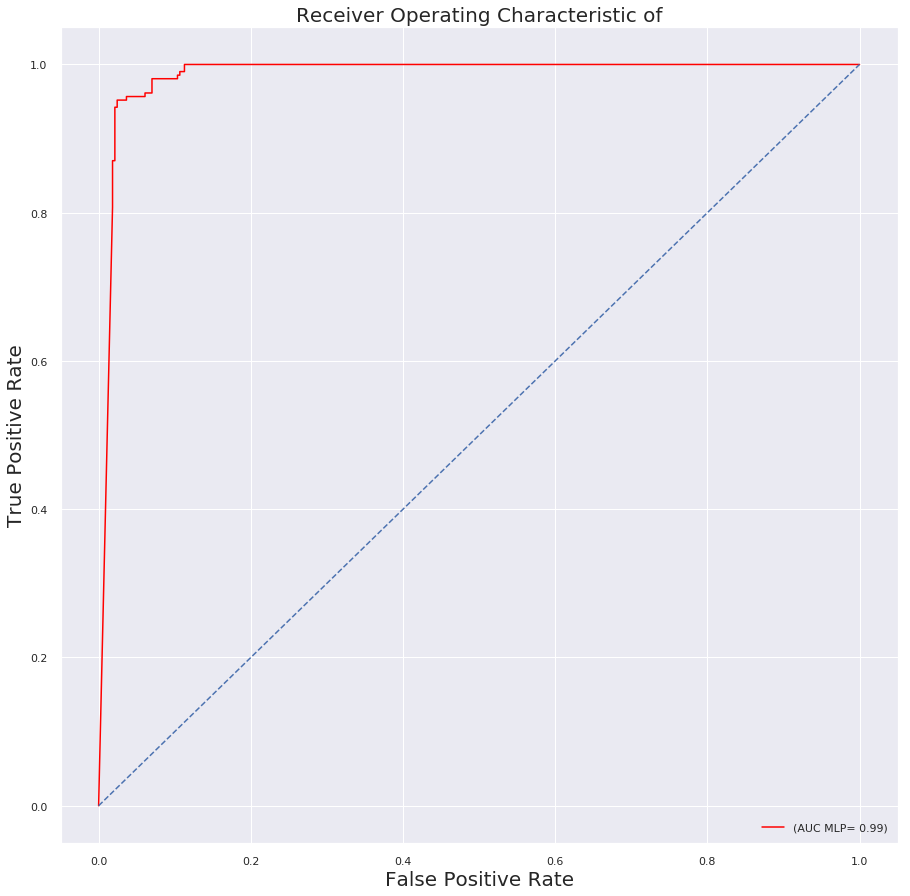

In [97]:
y_prob1 = clf.predict_proba(x_tests)[:,1]
y_prob0 = clf.predict_proba(x_tests)
y_prob2 = clf.predict_proba(x_tests)[:,0]
y_pred = clf.predict(x_tests)
clf.score(x_tests, y_pred)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_tests, y_prob1)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic of', fontsize = 20)
plt.plot(false_positive_rate,true_positive_rate, color='red',label = '(AUC MLP= %0.2f)' % roc_auc)
#plt.plot(fpr, tpr, color = 'g',label = 'AUC SVC= %0.2f' % Roc_Auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate',fontsize = 20)
plt.show()

In [98]:
clf.fit(x_trains, y_trains)
clf.score(x_trains, y_trains)  
# Predictions on the test dataset
MLPpredicted = pd.DataFrame(clf.predict(x_tests))  
# Probabilities on the test dataset
MLPprobs = pd.DataFrame(clf.predict_proba(x_tests))  
MLPprob0= pd.DataFrame(clf.predict_proba(x_tests)[:, 0])
MLPprob1 = pd.DataFrame(clf.predict_proba(x_tests)[:, 1])
MLP_accuracy= metrics.accuracy_score(y_tests, MLPpredicted)  
MLP_mcc = matthews_corrcoef(y_tests, MLPpredicted) 
MLP_precision = metrics.precision_score(y_tests, MLPpredicted, pos_label=1)  
MLP_recall = metrics.recall_score(y_tests, MLPpredicted, pos_label=1)  
MLP_f1 = metrics.f1_score(y_tests, MLPpredicted, pos_label=1)
#CROSS VAL
MLP_cv_scores = cross_val_score(clf , x_tests, y_tests, scoring='precision', cv=10)  
MLP_cv_mean = np.mean(MLP_cv_scores)
set_printoptions(precision=3)
MLP_cv_mean
MLP_cv_scores

array([0.947, 0.913, 0.913, 1.   , 0.909, 0.875, 0.875, 0.913, 0.9  ,
       0.909])

## Logistic regression Classifier

This is a probabilistic model for classification with nominal dependent variable. The logistic model classifier an input variable based on the probalilty of the class. 

In [99]:
def predictmodelLR(model):
    y_pred = model.predict(X_testl)
    f,t,thresholds = metrics.roc_curve(Y_testl,y_pred)
    cm = metrics.confusion_matrix(Y_testl,y_pred)
    
    print("Score:", metrics.auc(f,t))
    #print("Classification report:")
    #print(metrics.classification_report,Y_testl,y_pred)
    print("Confusion Matrix:")
    print(cm)

In [100]:
xl = data.loc[:,data.columns.tolist()[0:4]]
#xl = x.as_matrix()
Yl = data.loc[:,'Class']
#Yl = Y.as_matrix()
scaler = StandardScaler()
scaler.fit(xl)
x_trainl,x_testl,y_trainl,y_testl = train_test_split(xl,Yl,test_size=0.2,random_state=2700)
scaler = StandardScaler()
scaler.fit(x_trainl)
x_trains = scaler.transform(x_trainl)
scaler.fit(x_testl)
x_tests = scaler.transform(x_testl) 
X = scaler.transform(x)
LRs= LogisticRegression(C = 0.001,penalty='l2')
num_folds = 3
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed)
results = cross_val_score(LRs, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 65.770% (3.211%)


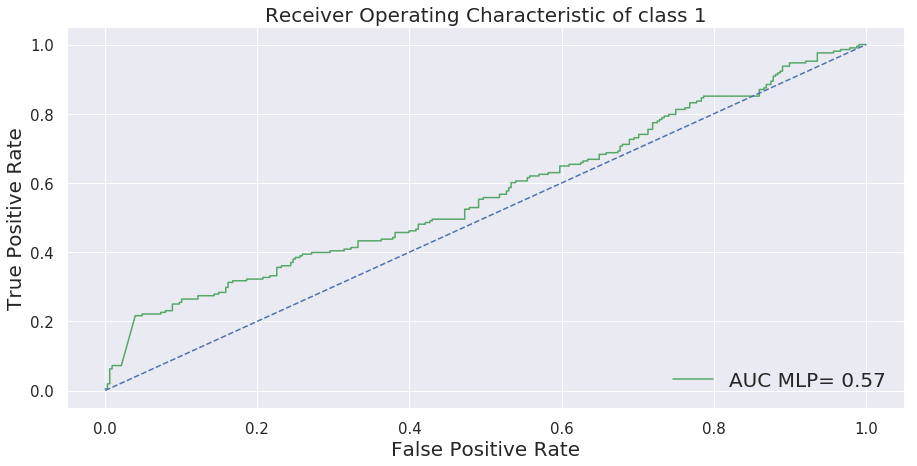

In [101]:
LRs.fit(x_trainl,y_trainl)
y_probl = LRs.predict_proba(x_testl)[:,1]
LRs.score(x_testl, y_pred)
from sklearn.metrics import roc_curve, auc
fprL, tprL, thresholds = roc_curve(y_testl, y_probl)
roc_aucL = auc(fprL, tprL)
roc_aucL

plt.plot(fprL, tprL, color='g',label = 'AUC MLP= %0.2f' % roc_aucL)
plt.title('Receiver Operating Characteristic of class 1', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 20)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.xticks(fontsize=15, rotation=None)
plt.yticks(fontsize=15, rotation=None)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate',fontsize = 20)
plt.show()

In [102]:
LRs= LogisticRegression(C = 0.001,penalty='l2')
LRs.fit(x_trainl, y_trainl) 
LRs.score(x_trainl, y_trainl)  
# Predictions on the test dataset
LRpredicted = pd.DataFrame(LRs.predict(x_testl))  
# Probabilities on the test dataset
LRprobs = pd.DataFrame(LRs.predict_proba(x_testl))  
prob0= pd.DataFrame(LRs.predict_proba(x_testl)[:, 0])
prob1 = pd.DataFrame(LRs.predict_proba(x_testl)[:, 1])
logit_mcc = matthews_corrcoef(y_test, LRpredicted) 
logit_accuracy= metrics.accuracy_score(y_testl, LRpredicted)  
logit_precision = metrics.precision_score(y_testl, LRpredicted, pos_label=1)  
logit_recall = metrics.recall_score(y_testl, LRpredicted, pos_label=1)  
logit_f1 = metrics.f1_score(y_testl, LRpredicted, pos_label=1)
#CROSS VAL
logit_cv_scores = cross_val_score(LRs, x_testl, y_testl, scoring='precision', cv=10)  
logit_cv_mean = np.mean(logit_cv_scores)

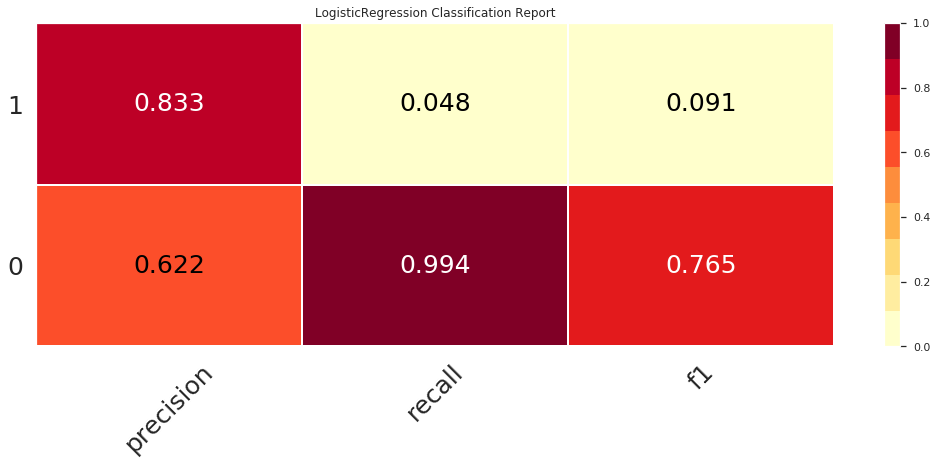

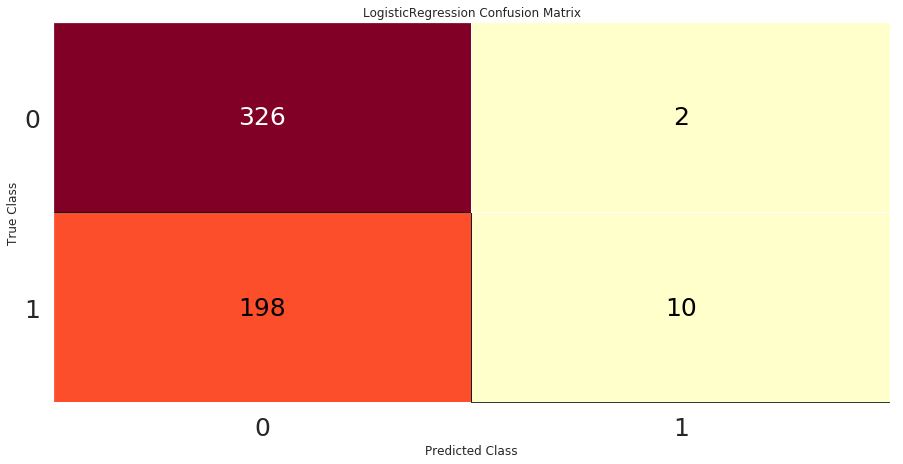

In [103]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 25
visualizer = ClassificationReport(LRs)
visualizer.fit(x_trainl, y_trainl)
visualizer.score(x_testl, y_testl)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)
visualizer.poof()
cm = ConfusionMatrix(LRs, classes=[0,1])
cm.fit(x_trainl, y_trainl)
cm.score(x_testl, y_testl)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)
cm.poof()

In [104]:
logit_mcc

0.13827642978260107

## k-nearest neighbors 

K nearest neighbor is a non parametric supervised machine learning that is does no making any assumption about the data. The algorithm learn all the instance in the training data set and in the test data it compares the distances(Euclidean or manhantta)  with the train and the lowest distance is return as the class of the predicted test class. The algorithm uses knowledge of training set to predict the test. low value of k can give high accuracy but also overfit the model. 

Score: 0.9009146341463414
Classification report:
             precision    recall  f1-score   support

          0       0.92      0.93      0.92       328
          1       0.88      0.88      0.88       208

avg / total       0.91      0.91      0.91       536

Confusion Matrix:
[[304  24]
 [ 26 182]]
Accuracy of K-NN classifier on test set: 0.91


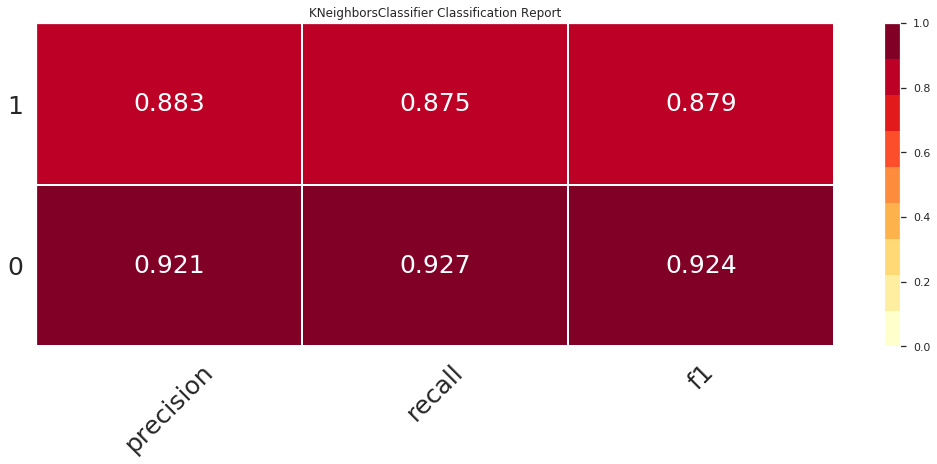

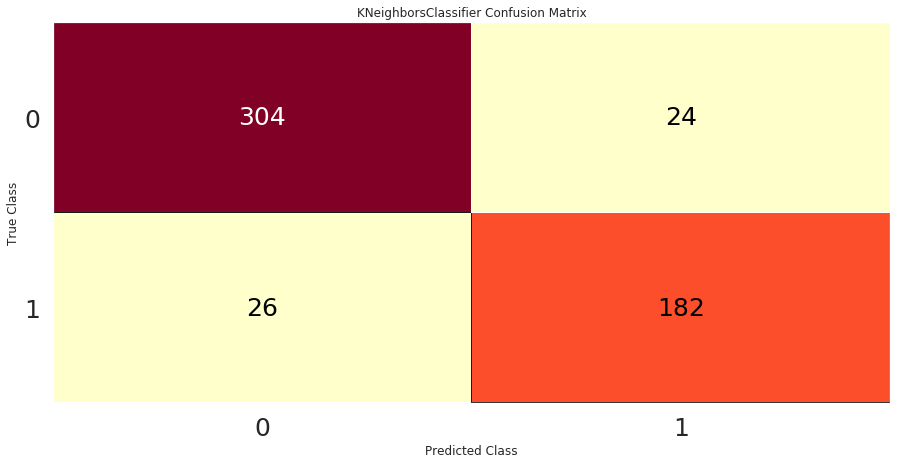

In [105]:
KNN = KNeighborsClassifier(n_neighbors=1, algorithm='auto',p=2, metric='minkowski')
KNN.fit(x_train , y_train)
predictmodel(KNN)
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(KNN.score(x_test, y_test)))

plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 25
visualizer = ClassificationReport(KNN)
visualizer.fit(x_train , y_train)
visualizer.score(x_test, y_test)
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25, rotation=None)
visualizer.poof()
cm = ConfusionMatrix(KNN, classes=[0,1])
cm.fit(x_train, y_train)
cm.score(x_test, y_test)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)
cm.poof()

In [106]:
KNN.fit(x_train , y_train)  
KNN.score(x_train, y_train)

# Predictions/probs on the test dataset
KNNpredicted = pd.DataFrame(KNN.predict(x_test))  
KNNprobs = pd.DataFrame(KNN.predict_proba(x_test))

# Store metrics
knn_accuracy = metrics.accuracy_score(y_test, KNNpredicted)  
knn_roc_auc = metrics.roc_auc_score(y_test, KNNprobs[1])  
knn_confus_matrix = metrics.confusion_matrix(y_test, KNNpredicted) 
knn_mcc = matthews_corrcoef(y_test, KNNpredicted) 
knn_classification_report = metrics.classification_report(y_test, KNNpredicted)  
knn_precision = metrics.precision_score(y_test, KNNpredicted, pos_label=1)  
knn_recall = metrics.recall_score(y_test, KNNpredicted, pos_label=1)  
knn_f1 = metrics.f1_score(y_test, KNNpredicted, pos_label=1)
# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNN, x_test, y_test, scoring='precision', cv=10)  
knn_cv_mean = np.mean(knn_cv_scores)  


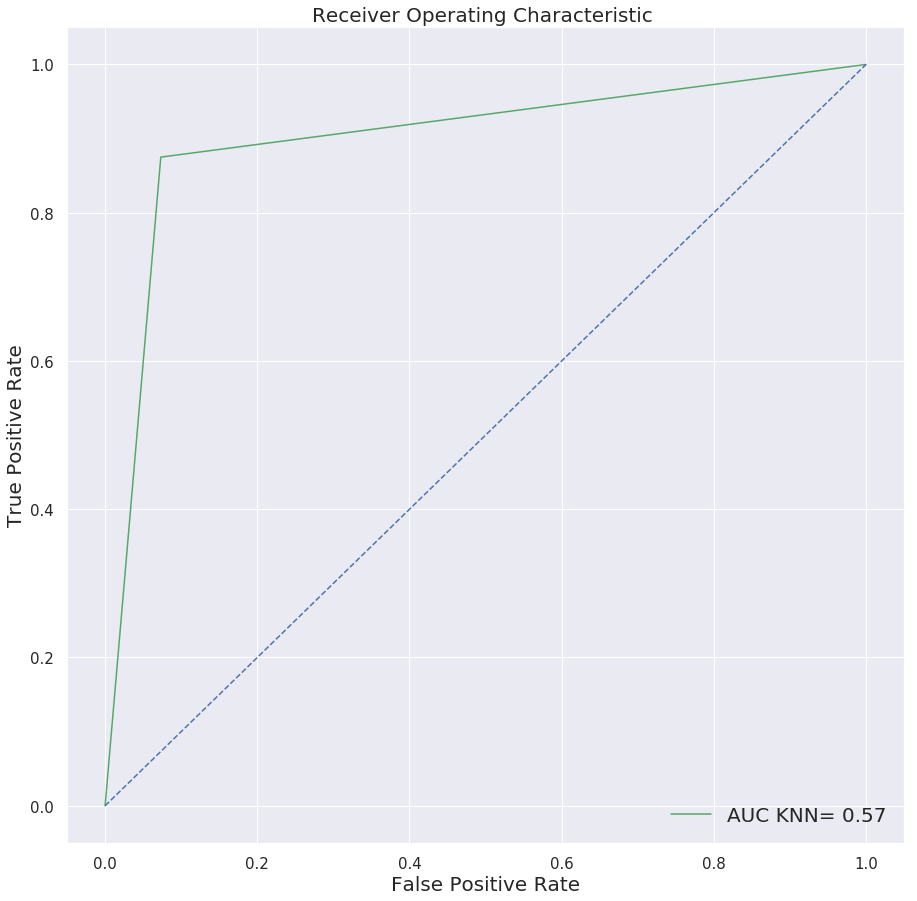

In [107]:

y_probk = KNN.predict_proba(x_test)[:,1]
LRs.score(x_test, y_pred)
from sklearn.metrics import roc_curve, auc
fprK, tprK, thresholdsK = roc_curve(y_test, y_probk)
roc_auck = auc(fprK, tprK)
roc_auck
plt.figure(figsize=(15,15))
plt.plot(fprK, tprK, color='g',label = 'AUC KNN= %0.2f' % roc_aucL)
plt.title('Receiver Operating Characteristic ', fontsize = 20)
plt.legend(loc = 'lower right',  fontsize = 20)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.xticks(fontsize=15, rotation=None)
plt.yticks(fontsize=15, rotation=None)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate',fontsize = 20)
plt.show()

In [108]:
# Model comparison
models = pd.DataFrame({  
  'Model': ['Logistic Regression', 'Support Vector Classifir', 'K-nearest Neighbor', 'Multi layer Perceptron'],
  'Accuracy' : [logit_accuracy, svm_accuracy, knn_accuracy, MLP_accuracy],
  'Precision': [logit_precision, svm_precision, knn_precision,MLP_precision],
  'recall' : [logit_recall, svm_recall, knn_recall, MLP_recall],
  'F1' : [logit_f1, svm_f1, knn_f1, MLP_f1],
  'cv_precision' :[logit_cv_mean, svm_cv_mean, knn_cv_mean,MLP_cv_mean],
  'Matthews Correlation Coefficient' :[logit_mcc, svm_mcc, knn_mcc,MLP_mcc]

})

#Print table and sort by test precision
models.sort_values(by='Accuracy', ascending=False)
models = models[['Model', 'Accuracy','F1','Precision','cv_precision','recall', 'Matthews Correlation Coefficient']]
models
#models.to_csv('performance.csv


,Model,Accuracy,F1,Precision,cv_precision,recall,Matthews Correlation Coefficient
0,Logistic Regression,0.626866,0.090909,0.833333,0.543071,0.048077,0.138276
1,Support Vector Classifir,0.942164,0.925301,0.927536,0.778346,0.923077,0.878124
2,K-nearest Neighbor,0.906716,0.879227,0.883495,0.710488,0.875000,0.803267
3,Multi layer Perceptron,0.904851,0.890792,0.803089,0.915468,1.000000,0.823540


# Compare Algorithms

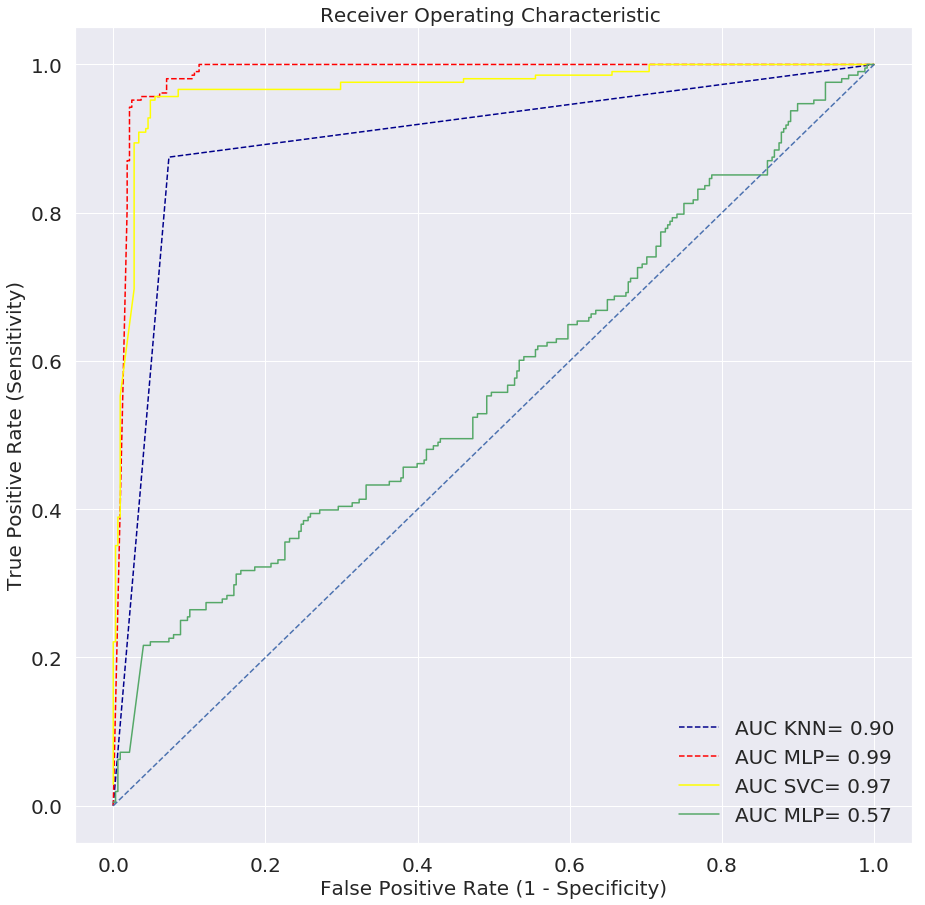

In [109]:
plt.figure(figsize = (15,15))
#plt.plot(fprL, tprL, color='g',label = 'AUC LR= %0.2f' % roc_aucL)
plt.plot(fprK, tprK, color='darkblue',linestyle='--',label = 'AUC KNN= %0.2f' % roc_auck)
plt.plot(false_positive_rate,true_positive_rate,linestyle='--',color='red',label = 'AUC MLP= %0.2f' % roc_auc)
plt.plot(fpr, tpr, color = 'yellow', linestyle='-',label = 'AUC SVC= %0.2f' % Roc_Auc)
plt.plot(fprL, tprL, color='g',label = 'AUC MLP= %0.2f' % roc_aucL)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 'lower right',fontsize = 20)
plt.rcParams['font.size'] = 12
plt.yticks(fontsize=20, rotation=None)
plt.xticks(fontsize=20, rotation=None)
plt.title('Receiver Operating Characteristic ' , fontsize = 20)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 20)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 20)
plt.plot([0, 1], [0, 1],linestyle='--',label = 'random ')
plt.axis('tight')
plt.grid(True)
plt.show()